<a href="https://colab.research.google.com/github/IonutMotoi/Thesis/blob/detectron2/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [1]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 276kB 7.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=0100089ad0251fd549a2756eaf96056d75410a8cc9ebebef4251196f2e39a6eb
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5MB 24kB/s 
     |████████████████████████████████| 17.3MB 190kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.0+cu101 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Succes

In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model

# Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [5]:
import pycocotools
from detectron2.structures import BoxMode

data_path = "/content/drive/MyDrive/Thesis/Mask RCNN/wgisd"

def get_wgisd_dicts(root, source):

  # Load the dataset subset defined by source
  if source not in ('train', 'test'):
      print('source should by "train" or "test"')
      return None

  source_path = os.path.join(root, f'{source}_masked.txt')
  with open(source_path, 'r') as fp:
      # Read all lines in file
      lines = fp.readlines()
      # Recover the items ids, removing the \n at the end
      ids = [l.rstrip() for l in lines]

  imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
  masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
  boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

  dataset_dicts = []
  for id in ids:
    record = {}
    
    filename = os.path.join(root, 'data', f'{id}.jpg')
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = id
    record["height"] = height
    record["width"] = width
  
    box_path = os.path.join(root, 'data', f'{id}.txt')
    mask_path = os.path.join(root, 'data', f'{id}.npz')

    wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
    num_objs = wgisd_masks.shape[2]

    boxes_text = np.loadtxt(box_path, delimiter=" ", dtype=np.float32)
    wgisd_boxes = boxes_text[:, 1:]
    assert (wgisd_boxes.shape[0] == num_objs)    

    objs = []
    for i in range(num_objs):
      box = wgisd_boxes[i]
      mask = wgisd_masks[:,:,i]

      # Boxes (x0, y0, w, h) in range [0, 1]
      # They are relative to the size of the image
      # Convert to (x0, y0, x1, y1) in absolute floating points coordinates
      x1 = box[0] - box[2] / 2
      x2 = box[0] + box[2] / 2
      y1 = box[1] - box[3] / 2
      y2 = box[1] + box[3] / 2
      box = [x1 * width, y1 * height, x2 * width, y2 * height]
      
      # Convert a uint8 mask of 0s and 1s into dict 
      # with keys “size” and “counts”
      mask = pycocotools.mask.encode(np.asarray(mask, order="F"))
      
      obj = {
          "bbox": box,
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": mask,
          "category_id": 0,
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts


for d in ["train", "test"]:
  dataset_name = "wgisd_" + d
  if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)

  DatasetCatalog.register(dataset_name, lambda d=d: get_wgisd_dicts(data_path, d))
  MetadataCatalog.get(dataset_name).set(thing_classes=["grapes"])

wgisd_metadata = MetadataCatalog.get("wgisd_train")

### Show examples

In [6]:
# # Show three GT examples from the train dataset

# dataset_dicts = get_wgisd_dicts(data_path, "train")
# for d in random.sample(dataset_dicts, 3):
# # for d in dataset_dicts:
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=wgisd_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

# Dataset (Bounding Boxes only)

In [7]:
import pycocotools
from detectron2.structures import BoxMode

data_path = "/content/drive/MyDrive/Thesis/Mask RCNN/wgisd"

def get_wgisd_BB_dicts(root, source):

  # Load the dataset subset defined by source
  if source not in ('train', 'test'):
      print('source should by "train" or "test"')
      return None

  source_path = os.path.join(root, f'{source}.txt')
  with open(source_path, 'r') as fp:
      # Read all lines in file
      lines = fp.readlines()
      # Recover the items ids, removing the \n at the end
      ids = [l.rstrip() for l in lines]

  imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
  boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

  dataset_dicts = []
  for id in ids:
    record = {}
    
    filename = os.path.join(root, 'data', f'{id}.jpg')
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = id
    record["height"] = height
    record["width"] = width
  
    box_path = os.path.join(root, 'data', f'{id}.txt')    
    boxes_text = np.loadtxt(box_path, delimiter=" ", dtype=np.float32)
    wgisd_boxes = boxes_text[:, 1:]
    num_objs = wgisd_boxes.shape[0]  

    objs = []
    for i in range(num_objs):
      box = wgisd_boxes[i]
      # Boxes (x0, y0, w, h) in range [0, 1]
      # They are relative to the size of the image
      # Convert to (x0, y0, x1, y1) in absolute floating points coordinates
      x1 = box[0] - box[2] / 2
      x2 = box[0] + box[2] / 2
      y1 = box[1] - box[3] / 2
      y2 = box[1] + box[3] / 2
      box = [x1 * width, y1 * height, x2 * width, y2 * height]

      # Bounding Box to Mask
      # mask = np.zeros((height,width), dtype=np.uint8)
      # mask[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = 1
      # Convert a uint8 mask of 0s and 1s into dict 
      # with keys “size” and “counts”
      # mask = pycocotools.mask.encode(np.asarray(mask, order="F"))

      obj = {
          "bbox": box,
          "bbox_mode": BoxMode.XYXY_ABS,
          # "segmentation": mask,
          "category_id": 0,
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts


for d in ["train", "test"]:
  dataset_name = "wgisd_BB_" + d
  if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    
  DatasetCatalog.register(dataset_name, lambda d=d: get_wgisd_BB_dicts(data_path, d))
  MetadataCatalog.get(dataset_name).set(thing_classes=["grapes"])

wgisd_BB_metadata = MetadataCatalog.get("wgisd_BB_train")

### Show examples (Bounding Boxes only)

In [8]:
# # Show three GT examples from the train dataset

# dataset_dicts = get_wgisd_BB_dicts(data_path, "train")
# for d in random.sample(dataset_dicts, 3):
# # for d in dataset_dicts:
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=wgisd_BB_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

# Mask R-CNN

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wgisd_BB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (grapes). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False

model = build_model(cfg)

In [ ]:
# mask_params = [p for p in model.roi_heads.mask_head.parameters()]
# for p in mask_params:
#  p.requires_grad = False

In [ ]:
# model.roi_heads

In [10]:
import logging
import os
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage

logger = logging.getLogger("detectron2")


def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type == "coco":
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)


def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


def do_train(cfg, model, resume=False, bb_only=False):
    model.train()
    # if bb_only:
    #   print("Dataset with bounding boxes only")
    #   for p in mask_params:
    #     p.requires_grad = False
    #   print("The parameters in the mask module have been frozen")
    # else:
    #   print("Dataset with masks")
    #   for p in mask_params:
    #     p.requires_grad = True
    #   print("The parameters in the mask module have been unfrozen")
    optimizer = build_optimizer(cfg, model)
    scheduler = build_lr_scheduler(cfg, optimizer)

    checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
    start_iter = (
        checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
    )
    max_iter = cfg.SOLVER.MAX_ITER

    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
    )

    writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

    # compared to "train_net.py", we do not support accurate timing and
    # precise BN here, because they are not trivial to implement in a small training loop
    data_loader = build_detection_train_loader(cfg)
    logger.info("Starting training from iteration {}".format(start_iter))
    with EventStorage(start_iter) as storage:
        for data, iteration in zip(data_loader, range(start_iter, max_iter)):
            storage.iter = iteration

            loss_dict = model(data)
            # if bb_only:
            #   loss_dict.pop('loss_mask')
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            scheduler.step()

            if (
                cfg.TEST.EVAL_PERIOD > 0
                and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
                and iteration != max_iter - 1
            ):
                do_test(cfg, model)
                # Compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            if iteration - start_iter > 5 and (
                (iteration + 1) % 20 == 0 or iteration == max_iter - 1
            ):
                for writer in writers:
                    writer.write()
            periodic_checkpointer.step(iteration)


def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(
        cfg, args
    )  # if you don't like any of the default setup, write your own setup code
    return cfg


# def main(args):
#     cfg = setup(args)

#     model = build_model(cfg)
#     logger.info("Model:\n{}".format(model))
#     if args.eval_only:
#         DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
#             cfg.MODEL.WEIGHTS, resume=args.resume
#         )
#         return do_test(cfg, model)

#     distributed = comm.get_world_size() > 1
#     if distributed:
#         model = DistributedDataParallel(
#             model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
#         )

#     do_train(cfg, model, resume=args.resume)
#     return do_test(cfg, model)


# if __name__ == "__main__":
#     args = default_argument_parser().parse_args()
#     print("Command Line Args:", args)
#     launch(
#         main,
#         args.num_gpus,
#         num_machines=args.num_machines,
#         machine_rank=args.machine_rank,
#         dist_url=args.dist_url,
#         args=(args,),
#     )


In [11]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
do_train(cfg, model, bb_only=True)

# trainer = Trainer(cfg, model) 
# trainer.resume_or_load(resume=False)
# trainer.train()

model_final_f10217.pkl: 178MB [00:01, 91.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[07/05 15:36:16 d2.data.build]: Removed 0 images with no usable annotations. 242 images left.
[07/05 15:36:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   grapes   | 3581         |
|            |              |
[07/05 15:36:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/05 15:36:16 d2.data.build]: Using training sampler TrainingSampler
[07/05 15:36:16 d2.data.common]: Serializing 242 elements to byte tensors and concatenating them all ...
[07/05 15:36:16 d2.data.common]: Serialized dataset takes 0.40 MiB
[07/05 15:36:16 detectron2]: Starting training from iteration 0
[07/05 15:36:25 d2.utils.events]:  iter: 19  total_loss: 1.192  loss_cls: 0.5921  loss_box_reg: 0.1803  loss_rpn_cls: 0.3352  loss_rpn_loc: 0.09345  lr: 4.9953e-06  max_mem: 2516M
[07/0

In [20]:
# Use the weights of the model pretrained on the bounding box only dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.MASK_ON = True
cfg.INPUT.MASK_FORMAT = "bitmask"
model = build_model(cfg)

In [21]:
# Train on the instance segmentation dataset
cfg.DATASETS.TRAIN = ("wgisd_train",)
cfg.SOLVER.MAX_ITER = 2000 # 300 + 300
do_train(cfg, model, resume=True)

[07/05 15:56:24 d2.data.build]: Removed 0 images with no usable annotations. 110 images left.
[07/05 15:56:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/05 15:56:24 d2.data.build]: Using training sampler TrainingSampler
[07/05 15:56:24 d2.data.common]: Serializing 110 elements to byte tensors and concatenating them all ...
[07/05 15:56:24 d2.data.common]: Serialized dataset takes 1.50 MiB
[07/05 15:56:24 detectron2]: Starting training from iteration 600


/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:419: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:419: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. T

[07/05 15:56:42 d2.utils.events]:  iter: 619  total_loss: 1.723  loss_cls: 0.3632  loss_box_reg: 0.5882  loss_mask: 0.6526  loss_rpn_cls: 0.04488  loss_rpn_loc: 0.0753  lr: 7.992e-05  max_mem: 4811M
[07/05 15:57:00 d2.utils.events]:  eta: 0:19:38  iter: 639  total_loss: 1.757  loss_cls: 0.3549  loss_box_reg: 0.5855  loss_mask: 0.6513  loss_rpn_cls: 0.04841  loss_rpn_loc: 0.07508  lr: 8.4915e-05  max_mem: 4839M
[07/05 15:57:16 d2.utils.events]:  eta: 0:18:46  iter: 659  total_loss: 1.695  loss_cls: 0.3533  loss_box_reg: 0.5953  loss_mask: 0.6528  loss_rpn_cls: 0.04102  loss_rpn_loc: 0.06816  lr: 8.991e-05  max_mem: 4839M
[07/05 15:57:34 d2.utils.events]:  eta: 0:19:27  iter: 679  total_loss: 1.723  loss_cls: 0.3649  loss_box_reg: 0.5922  loss_mask: 0.6447  loss_rpn_cls: 0.05094  loss_rpn_loc: 0.0707  lr: 9.4905e-05  max_mem: 4891M
[07/05 15:57:50 d2.utils.events]:  eta: 0:17:49  iter: 699  total_loss: 1.613  loss_cls: 0.3322  loss_box_reg: 0.5492  loss_mask: 0.6444  loss_rpn_cls: 0.0344

# Validation

In [22]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

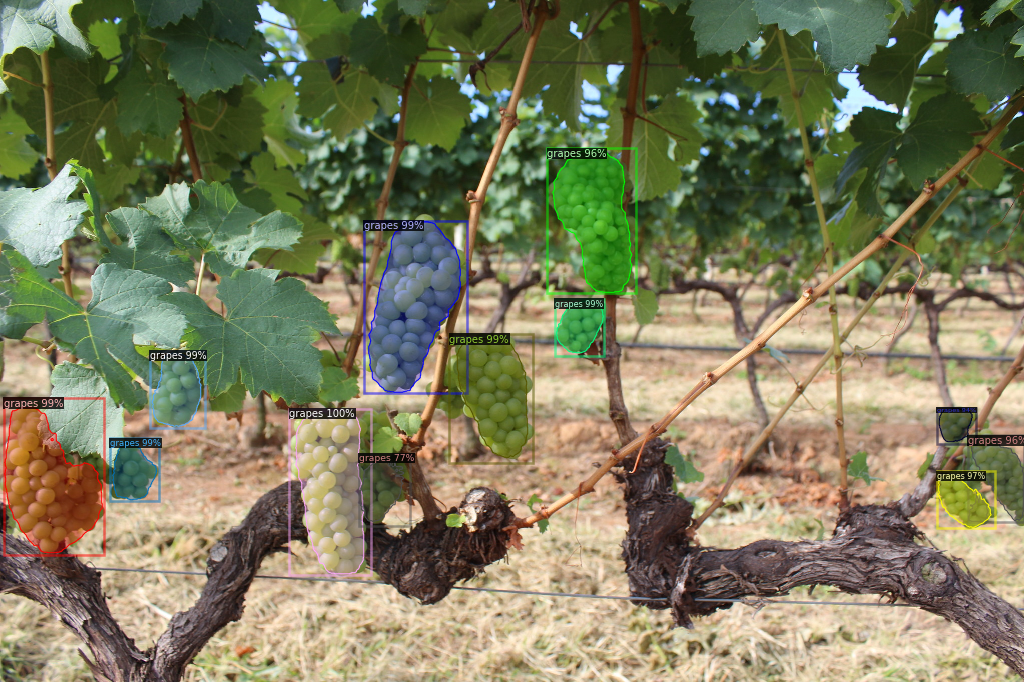

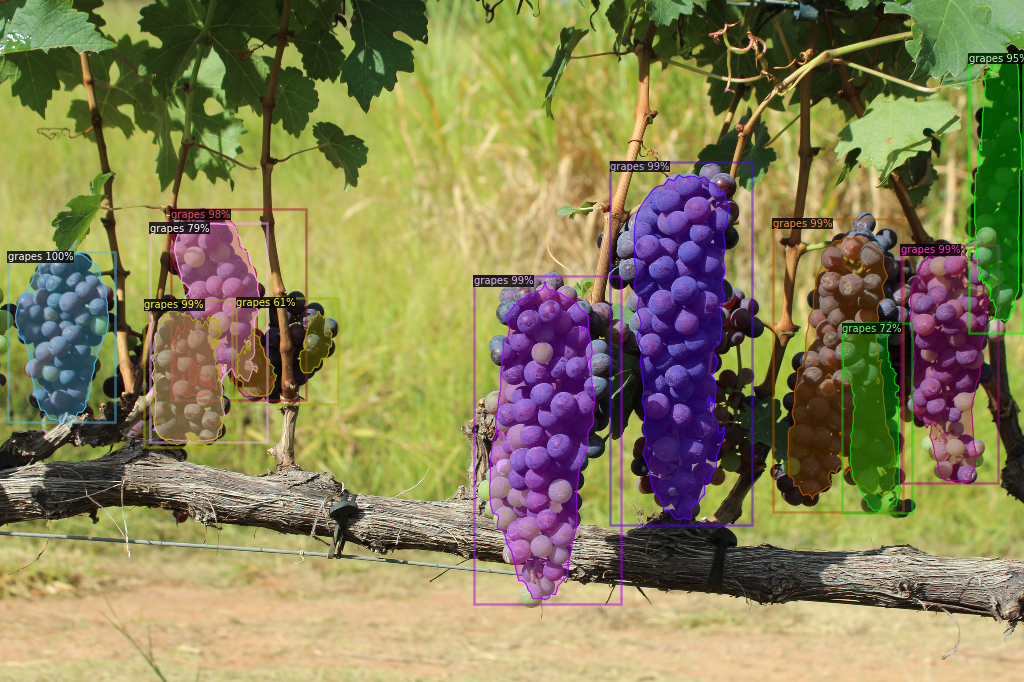

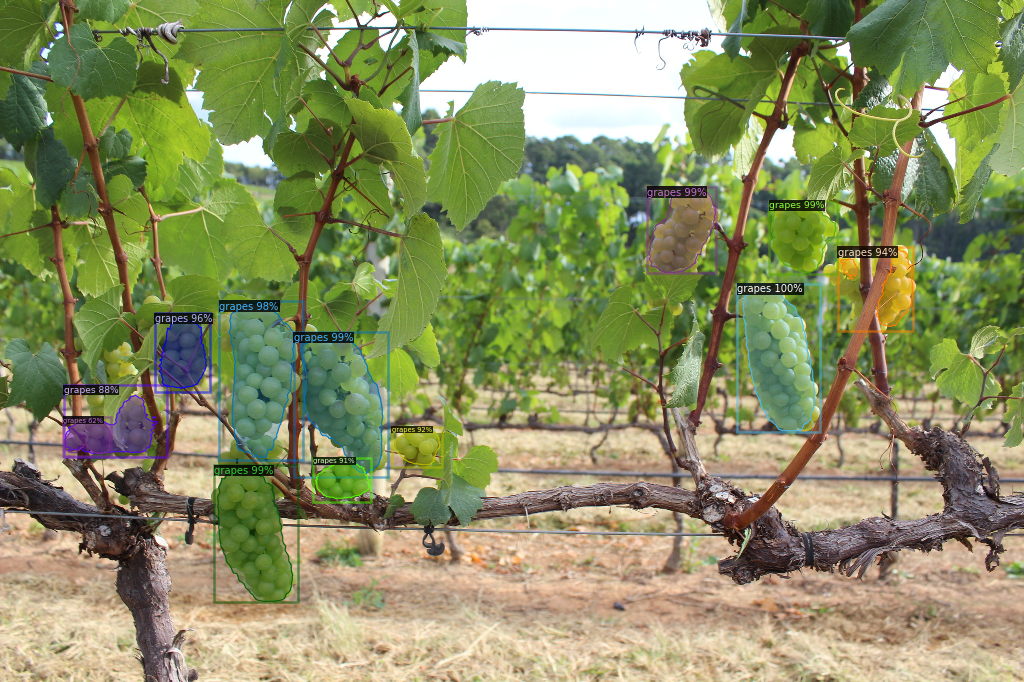

In [23]:
# Show some examples of predictions on the validation dataset

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_wgisd_dicts(data_path, "test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=wgisd_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [24]:
# Evaluate (COCO) on the validation dataset

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wgisd_test", ("bbox", "segm"), False, output_dir="./output/")
# evaluator = COCOEvaluator("wgisd_BB_test", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "wgisd_test")
print(inference_on_dataset(model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[07/05 16:19:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/05 16:19:02 d2.data.common]: Serializing 27 elements to byte tensors and concatenating them all ...
[07/05 16:19:02 d2.data.common]: Serialized dataset takes 0.40 MiB
[07/05 16:19:02 d2.evaluation.evaluator]: Start inference on 27 images
[07/05 16:19:07 d2.evaluation.evaluator]: Inference done 11/27. 0.1339 s / img. ETA=0:00:06
[07/05 16:19:12 d2.evaluation.evaluator]: Inference done 24/27. 0.1325 s / img. ETA=0:00:01
[07/05 16:19:13 d2.evaluation.evaluator]: Total inference time: 0:00:08.756430 (0.398020 s / img per device, on 1 devices)
[07/05 16:19:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.131635 s / img per device, on 1 devices)
[07/05 16:19:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/05 16:19:13 d2.evaluation.coco_evaluation]: Saving re